In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "5 parts_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 100, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.05, transfer_ratio= 0.4):
    trainloader = []
    valloader = []
    traindata_list = []
    trainlabel_list = []
    valdata_list = []
    vallabel_list = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        test_ratio = 1 - (train_ratio + val_ratio)
        print(test_ratio)
        test_size = int(test_ratio * len(dataset))
        print(test_size)
        transfer_size = int((len(dataset) - test_size)*transfer_ratio)
        train_size_t = int(train_ratio * transfer_size)
        val_size_t = transfer_size - train_size_t
        centralized_size = len(dataset) - (transfer_size + test_size)
        train_size = int(centralized_size * train_ratio)
        val_size = centralized_size - train_size

        train_dataset, val_dataset, test_dataset, train_dataset_transfer, val_dataset_transfer = random_split(dataset, [train_size, val_size, test_size, train_size_t, val_size_t])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))

        traindata_list.append(train_dataset_transfer.dataset.tensors[0][train_dataset_transfer.indices])
        trainlabel_list.append(train_dataset_transfer.dataset.tensors[1][train_dataset_transfer.indices])
        valdata_list.append(val_dataset_transfer.dataset.tensors[0][val_dataset_transfer.indices])
        vallabel_list.append(val_dataset_transfer.dataset.tensors[1][val_dataset_transfer.indices])
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    traindata = torch.cat(traindata_list, dim=0)
    trainlabels = torch.cat(trainlabel_list, dim=0)
    valdata = torch.cat(valdata_list, dim=0)
    vallabels = torch.cat(vallabel_list, dim=0)
    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    trainloader_transfer = DataLoader(TensorDataset(traindata, trainlabels), batch_size=batch_size, shuffle=False)
    valloader_transfer = DataLoader(TensorDataset(valdata, vallabels), batch_size=batch_size, shuffle=False)
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 49.72627639770508 Testing accuracy: 51.8248176574707.

Epoch 2/100
Epoch 2: Training accuracy: 55.56569290161133 Testing accuracy: 52.554744720458984.

Epoch 3/100
Epoch 3: Training accuracy: 65.41970825195312 Testing accuracy: 65.69342803955078.

Epoch 4/100
Epoch 4: Training accuracy: 59.489051818847656 Testing accuracy: 55.47445297241211.

Epoch 5/100
Epoch 5: Training accuracy: 62.04379653930664 Testing accuracy: 62.04379653930664.

Epoch 6/100
Epoch 6: Training accuracy: 62.22627639770508 Testing accuracy: 61.31386947631836.

Epoch 7/100
Epoch 7: Training accuracy: 65.14598846435547 Testing accuracy: 63.5036506652832.

Epoch 8/100
Epoch 8: Training accuracy: 65.78466796875 Testing accuracy: 62.77372360229492.

Epoch 9/100
Epoch 9: Training accuracy: 71.44160461425781 Testing accuracy: 67.88320922851562.

Epoch 10/100
Epoch 10: Training accuracy: 68.15693664550781 Testing accuracy: 65.69342803955078.

Epoch 11/100
Epoch 11: Training accuracy

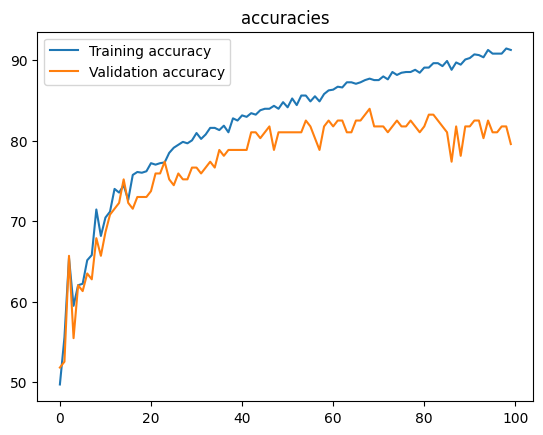

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, valloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## transfer learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

0.1499999999999999
250
0.1499999999999999
233
0.1499999999999999
310
0.1499999999999999
253



Epoch 1/100
Epoch 1: Training accuracy: 57.894737243652344 Testing accuracy: 54.411766052246094.

Epoch 2/100
Epoch 2: Training accuracy: 67.0 Testing accuracy: 62.60504150390625.

Epoch 3/100
Epoch 3: Training accuracy: 70.0 Testing accuracy: 64.07563018798828.

Epoch 4/100
Epoch 4: Training accuracy: 72.10526275634766 Testing accuracy: 64.70587921142578.

Epoch 5/100
Epoch 5: Training accuracy: 73.47368621826172 Testing accuracy: 66.17646789550781.

Epoch 6/100
Epoch 6: Training accuracy: 74.9473648071289 Testing accuracy: 67.43697357177734.

Epoch 7/100
Epoch 7: Training accuracy: 76.31578826904297 Testing accuracy: 68.90756225585938.

Epoch 8/100
Epoch 8: Training accuracy: 77.68421173095703 Testing accuracy: 70.3781509399414.

Epoch 9/100
Epoch 9: Training accuracy: 78.21052551269531 Testing accuracy: 70.5882339477539.

Epoch 10/100
Epoch 10: Training accuracy: 78.78947448730469 Testing accuracy: 70.7983169555664.

Epoch 11/100
Epoch 11: Training accuracy: 79.42105102539062 Testi

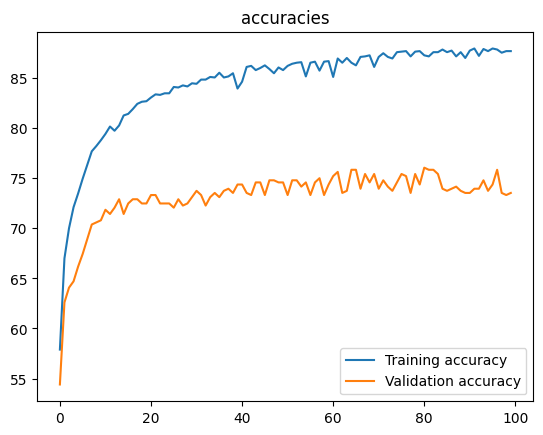

In [8]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'])
    loss, accuracy = test(net, azure_val_loaders_transfer, configuration)
    losses_transfer.append(loss)
    accuracies_transfer.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Learning

In [9]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [10]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [12]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-08-12 10:41:51,223	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:192.168.1.146': 1.0, 'memory': 126037108122.0, 'object_store_memory': 58301617766.0, 'CPU': 32.0, 'node:__internal_head__': 1.0, 'GPU': 2.0, 'accelerator_type:G': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.044176925631130445 / accuracy 48.56596374511719
(ClientAppActor pid=2224420) 
(ClientAppActor pid=2224420) Epoch 1/100
(ClientAppActor pid=2224421) Epoch 1: Training accuracy: 48.82260513305664 Testing accuracy: 48.75.
(ClientAppActor pid=2224421) Epoch 2: Training accuracy: 48.82260513305664 Testing accuracy: 48.75.


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.04074811935424805, {'accuracy': tensor(53.0593, device='cuda:0')}, 4.479602686944418)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04074811935424805 / accuracy 53.05927276611328
(ClientAppActor pid=2224420)  [repeated 641x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2224420) Epoch 24/100 [repeated 641x across cluster]
(ClientAppActor pid=2224420) Epoch 29: Training accuracy: 50.0 Testing accuracy: 44.81132125854492. [repeated 652x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.04066780735464657, {'accuracy': tensor(65.1052, device='cuda:0')}, 7.7247335070278496)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04066780735464657 / accuracy 65.10516357421875


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.0404848105767194, {'accuracy': tensor(51.6252, device='cuda:0')}, 10.867417735047638)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0404848105767194 / accuracy 51.625240325927734
(ClientAppActor pid=2224420)  [repeated 609x across cluster]
(ClientAppActor pid=2224420) Epoch 32/100 [repeated 609x across cluster]
(ClientAppActor pid=2224420) Epoch 39: Training accuracy: 53.01028060913086 Testing accuracy: 46.783626556396484. [repeated 608x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.04036667417077457, {'accuracy': tensor(70.4589, device='cuda:0')}, 14.02586583502125)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04036667417077457 / accuracy 70.45889282226562
(ClientAppActor pid=2224420)  [repeated 663x across cluster]
(ClientAppActor pid=2224420) Epoch 45/100 [repeated 663x across cluster]
(ClientAppActor pid=2224420) Epoch 52: Training accuracy: 60.35242462158203 Testing accuracy: 56.140350341796875. [repeated 665x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.04002664019079769, {'accuracy': tensor(71.6061, device='cuda:0')}, 17.235668375971727)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04002664019079769 / accuracy 71.60611724853516


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.039356613860410804, {'accuracy': tensor(71.6061, device='cuda:0')}, 20.557557136984542)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.039356613860410804 / accuracy 71.60611724853516
(ClientAppActor pid=2224420)  [repeated 618x across cluster]
(ClientAppActor pid=2224420) Epoch 68/100 [repeated 618x across cluster]
(ClientAppActor pid=2224420) Epoch 75: Training accuracy: 66.9603500366211 Testing accuracy: 64.32748413085938. [repeated 619x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.038504712721880746, {'accuracy': tensor(72.0841, device='cuda:0')}, 23.696565591963008)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.038504712721880746 / accuracy 72.0841293334961
(ClientAppActor pid=2224421)  [repeated 648x across cluster]
(ClientAppActor pid=2224421) Epoch 100/100 [repeated 648x across cluster]
(ClientAppActor pid=2224420) Epoch 86: Training accuracy: 75.23696899414062 Testing accuracy: 66.50943756103516. [repeated 640x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.03748486322515151, {'accuracy': tensor(72.1797, device='cuda:0')}, 26.912529323948547)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03748486322515151 / accuracy 72.17973327636719


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.03662024175419527, {'accuracy': tensor(72.2753, device='cuda:0')}, 30.0421706760535)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03662024175419527 / accuracy 72.27533721923828
(ClientAppActor pid=2224420)  [repeated 594x across cluster]
(ClientAppActor pid=2224420) Epoch 81/100 [repeated 594x across cluster]
(ClientAppActor pid=2224420) Epoch 86: Training accuracy: 73.34123229980469 Testing accuracy: 69.81131744384766. [repeated 599x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.03591972589492798, {'accuracy': tensor(72.4665, device='cuda:0')}, 33.29276767396368)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 rounds in 33.32s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.19800286633627756\n'
INFO :      	 '\tround 2: 0.1976651464189802\n'
INFO :      	 '\tround 3: 0.22948230306307474\n'
INFO :      	 '\tround 4: 0.19687363931110927\n'
INFO :      	 '\tround 5: 0.22659257054328918\n'
INFO :      	 '\tround 6: 0.19058273519788468\n'
INFO :      	 '\tround 7: 0.2193662722905477\n'
INFO :      	 '\tround 8: 0.1810204897608076\n'
INFO :      	 '\tround 9: 0.20813204844792685\n'
INFO :      	 '\tround 10: 0.2120883266131083\n')History (loss, centralized):
INFO :      	('\tround 0: 0.044176925631130445\

Server-side evaluation loss 0.03591972589492798 / accuracy 72.46653747558594


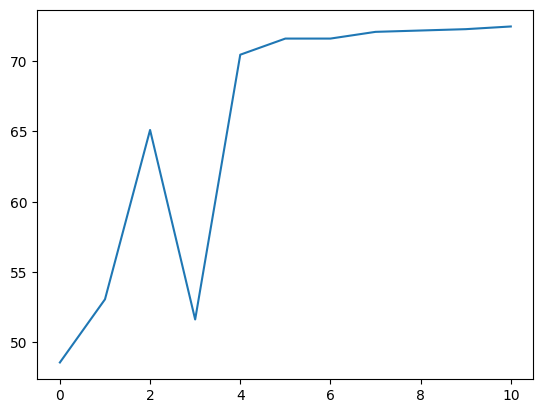

*** SIGTERM received at time=1723455798 on cpu 8 ***
PC: @     0x7f938643ee2e  (unknown)  epoll_wait
    @     0x7f938635b520  (unknown)  (unknown)
[2024-08-12 10:43:18,627 E 2223331 2223331] logging.cc:361: *** SIGTERM received at time=1723455798 on cpu 8 ***
[2024-08-12 10:43:18,627 E 2223331 2223331] logging.cc:361: PC: @     0x7f938643ee2e  (unknown)  epoll_wait
[2024-08-12 10:43:18,627 E 2223331 2223331] logging.cc:361:     @     0x7f938635b520  (unknown)  (unknown)


In [13]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')